# Top 50 SPX Components: 10-Year Realized Volatility Analysis
## Individual Component Volatilities vs SPX Index - Complete Historical View
### Visualize 10 years of realized volatility for all top 50 SPX components alongside the SPX Index to understand diversification benefits and individual component behavior.

#### Setup and Data Preparation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("📊 TOP 50 BENCHMARK vs SPX INDEX: 10-YEAR COMPARISON")
print("=" * 70)
print("Market cap weighted concentrated portfolio vs full index analysis")

📊 TOP 50 BENCHMARK vs SPX INDEX: 10-YEAR COMPARISON
Market cap weighted concentrated portfolio vs full index analysis


In [14]:
# Load the 10-year volatility data
vol_data_path = '../data/historical_volatility/ten_year_volatility_latest.csv'
vol_df = pd.read_csv(vol_data_path)
vol_df['date'] = pd.to_datetime(vol_df['date'])

# Load SPX weights to get top 50 components with proper weights
weights_path = '../data/processed/spx_weights/spx_weights_latest.csv'

try:
    weights_df = pd.read_csv(weights_path)
    top_50_weights = weights_df.head(50).copy()
    
    # Normalize weights to sum to 100% (for the top 50 subset)
    total_weight = top_50_weights['market_cap_weight_pct'].sum()
    top_50_weights['normalized_weight'] = (top_50_weights['market_cap_weight_pct'] / total_weight) * 100
    
    print(f"✅ Using market cap weights for Top 50 benchmark")
    print(f"   Top 50 represents {total_weight:.1f}% of full SPX market cap")
    print(f"   Normalized to 100% for benchmark construction")
    
except FileNotFoundError:
    print("⚠️ Using equal weights for Top 50 benchmark")
    # Get top 50 components from volatility data
    component_tickers = vol_df[vol_df['ticker'] != 'SPX Index']['ticker'].unique()[:50]
    top_50_weights = pd.DataFrame({
        'ticker': component_tickers,
        'normalized_weight': [100/50] * 50  # Equal 2% weights
    })

# Show top 10 holdings in the benchmark
print(f"\nTop 10 holdings in Top 50 Benchmark:")
for i, row in top_50_weights.head(10).iterrows():
    ticker_clean = row['ticker'].replace(' US Equity', '')
    print(f"   {i+1:2d}. {ticker_clean:8s} {row['normalized_weight']:5.2f}%")

✅ Using market cap weights for Top 50 benchmark
   Top 50 represents 75.1% of full SPX market cap
   Normalized to 100% for benchmark construction

Top 10 holdings in Top 50 Benchmark:
    1. NVDA     18.45%
    2. AAPL     13.83%
    3. AMZN     10.53%
    4. META      7.76%
    5. AVGO      5.84%
    6. V         3.03%
    7. NFLX      2.25%
    8. MA        2.20%
    9. XOM       2.04%
   10. PG        1.59%


#### Calculate Top 50 Benchmark Volatility

In [15]:
def calculate_top50_benchmark_volatility(vol_data, weights_df, vol_field='realized_vol_252d'):
    """
    Calculate market cap weighted Top 50 benchmark realized volatility
    """
    print(f"\n📈 CALCULATING TOP 50 BENCHMARK VOLATILITY ({vol_field})")
    print("=" * 60)
    
    # Get realized volatility data
    realized_data = vol_data[vol_data['data_type'] == 'realized'].copy()
    
    # Create weights lookup
    weights_lookup = weights_df.set_index('ticker')['normalized_weight'].to_dict()
    
    # Filter for components with both data and weights
    valid_tickers = []
    for ticker in weights_df['ticker']:
        ticker_data = realized_data[realized_data['ticker'] == ticker]
        if len(ticker_data) > 0 and ticker_data[vol_field].notna().sum() > 100:
            valid_tickers.append(ticker)
    
    print(f"Valid components with data: {len(valid_tickers)}/{len(weights_df)}")
    
    # Calculate daily benchmark volatility
    all_dates = sorted(realized_data['date'].unique())
    benchmark_volatility = []
    
    for date in all_dates:
        date_data = realized_data[realized_data['date'] == date]
        
        # Get volatility for valid components on this date
        date_vol_data = {}
        total_weight_available = 0
        
        for ticker in valid_tickers:
            ticker_row = date_data[date_data['ticker'] == ticker]
            if len(ticker_row) > 0 and ticker_row[vol_field].notna().iloc[0]:
                vol_value = ticker_row[vol_field].iloc[0]
                weight = weights_lookup[ticker]
                date_vol_data[ticker] = {'vol': vol_value, 'weight': weight}
                total_weight_available += weight
        
        # Calculate weighted average if we have sufficient coverage
        if total_weight_available > 60:  # At least 60% weight coverage
            weighted_vol = 0
            for ticker, data in date_vol_data.items():
                # Normalize weight to available coverage
                normalized_weight = (data['weight'] / total_weight_available)
                weighted_vol += data['vol'] * normalized_weight
            
            benchmark_volatility.append({
                'date': date,
                'top50_benchmark_vol': weighted_vol,
                'weight_coverage': total_weight_available,
                'components_count': len(date_vol_data)
            })
    
    benchmark_vol_df = pd.DataFrame(benchmark_volatility)
    print(f"Calculated Top 50 benchmark volatility for {len(benchmark_vol_df):,} dates")
    print(f"Average weight coverage: {benchmark_vol_df['weight_coverage'].mean():.1f}%")
    print(f"Average components per date: {benchmark_vol_df['components_count'].mean():.1f}")
    
    return benchmark_vol_df

# Calculate Top 50 benchmark volatility
top50_benchmark_252d = calculate_top50_benchmark_volatility(vol_df, top_50_weights, 'realized_vol_252d')
top50_benchmark_90d = calculate_top50_benchmark_volatility(vol_df, top_50_weights, 'realized_vol_90d')


📈 CALCULATING TOP 50 BENCHMARK VOLATILITY (realized_vol_252d)
Valid components with data: 50/50
Calculated Top 50 benchmark volatility for 2,515 dates
Average weight coverage: 99.4%
Average components per date: 49.1

📈 CALCULATING TOP 50 BENCHMARK VOLATILITY (realized_vol_90d)
Valid components with data: 50/50
Calculated Top 50 benchmark volatility for 2,515 dates
Average weight coverage: 99.5%
Average components per date: 49.2


#### Get SPX Index Data for Comparison

In [16]:
# Get SPX Index realized volatility
spx_realized = vol_df[
    (vol_df['ticker'] == 'SPX Index') & 
    (vol_df['data_type'] == 'realized')
].copy()

print(f"\n📊 SPX INDEX DATA")
print(f"   SPX observations: {len(spx_realized):,}")
print(f"   252D vol data points: {spx_realized['realized_vol_252d'].notna().sum():,}")
print(f"   90D vol data points: {spx_realized['realized_vol_90d'].notna().sum():,}")

# Create comparison datasets
comparison_252d = pd.merge(
    top50_benchmark_252d[['date', 'top50_benchmark_vol', 'weight_coverage']], 
    spx_realized[['date', 'realized_vol_252d']].rename(columns={'realized_vol_252d': 'spx_vol'}),
    on='date', 
    how='inner'
)

comparison_90d = pd.merge(
    top50_benchmark_90d[['date', 'top50_benchmark_vol', 'weight_coverage']], 
    spx_realized[['date', 'realized_vol_90d']].rename(columns={'realized_vol_90d': 'spx_vol'}),
    on='date', 
    how='inner'
)

print(f"\nComparison datasets:")
print(f"   252D comparison: {len(comparison_252d):,} overlapping dates")
print(f"   90D comparison: {len(comparison_90d):,} overlapping dates")
print(f"   Date range: {comparison_252d['date'].min().strftime('%Y-%m-%d')} to {comparison_252d['date'].max().strftime('%Y-%m-%d')}")


📊 SPX INDEX DATA
   SPX observations: 2,515
   252D vol data points: 2,515
   90D vol data points: 2,515

Comparison datasets:
   252D comparison: 2,515 overlapping dates
   90D comparison: 2,515 overlapping dates
   Date range: 2015-07-20 to 2025-07-18


#### Create Clean Two-Line Volatility Chart

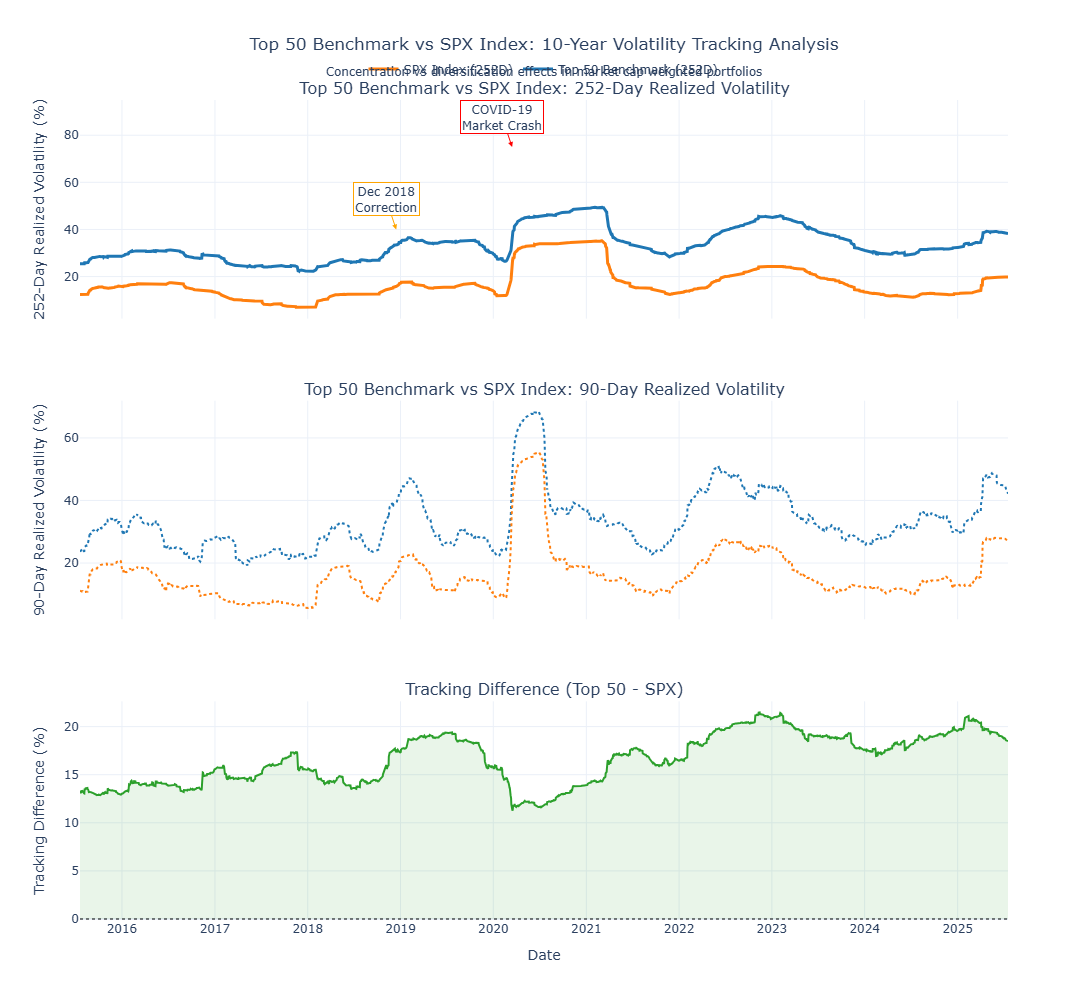

In [17]:
# Create the main comparison chart
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        'Top 50 Benchmark vs SPX Index: 252-Day Realized Volatility',
        'Top 50 Benchmark vs SPX Index: 90-Day Realized Volatility',
        'Tracking Difference (Top 50 - SPX)'
    ],
    vertical_spacing=0.1,
    shared_xaxes=True
)

# Colors
top50_color = '#1f77b4'  # Blue
spx_color = '#ff7f0e'    # Orange
diff_color = '#2ca02c'   # Green

# Plot 1: 252-day comparison
if len(comparison_252d) > 0:
    fig.add_trace(
        go.Scatter(
            x=comparison_252d['date'],
            y=comparison_252d['top50_benchmark_vol'],
            mode='lines',
            name='Top 50 Benchmark (252D)',
            line=dict(color=top50_color, width=3),
            hovertemplate='<b>Top 50 Benchmark</b><br>Date: %{x}<br>252D Vol: %{y:.2f}%<extra></extra>'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=comparison_252d['date'],
            y=comparison_252d['spx_vol'],
            mode='lines',
            name='SPX Index (252D)',
            line=dict(color=spx_color, width=3),
            hovertemplate='<b>SPX Index</b><br>Date: %{x}<br>252D Vol: %{y:.2f}%<extra></extra>'
        ),
        row=1, col=1
    )

# Plot 2: 90-day comparison
if len(comparison_90d) > 0:
    fig.add_trace(
        go.Scatter(
            x=comparison_90d['date'],
            y=comparison_90d['top50_benchmark_vol'],
            mode='lines',
            name='Top 50 Benchmark (90D)',
            line=dict(color=top50_color, width=2, dash='dot'),
            hovertemplate='<b>Top 50 Benchmark</b><br>Date: %{x}<br>90D Vol: %{y:.2f}%<extra></extra>',
            showlegend=False
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=comparison_90d['date'],
            y=comparison_90d['spx_vol'],
            mode='lines',
            name='SPX Index (90D)',
            line=dict(color=spx_color, width=2, dash='dot'),
            hovertemplate='<b>SPX Index</b><br>Date: %{x}<br>90D Vol: %{y:.2f}%<extra></extra>',
            showlegend=False
        ),
        row=2, col=1
    )

# Plot 3: Tracking difference
if len(comparison_252d) > 0:
    tracking_diff = comparison_252d['top50_benchmark_vol'] - comparison_252d['spx_vol']
    
    fig.add_trace(
        go.Scatter(
            x=comparison_252d['date'],
            y=tracking_diff,
            mode='lines',
            name='Tracking Difference',
            line=dict(color=diff_color, width=2),
            fill='tonexty',
            fillcolor='rgba(44, 160, 44, 0.1)',
            hovertemplate='<b>Tracking Difference</b><br>Date: %{x}<br>Top50 - SPX: %{y:.2f}%<extra></extra>',
            showlegend=False
        ),
        row=3, col=1
    )
    
    # Add zero line for tracking difference
    fig.add_hline(y=0, line_dash="dot", line_color="black", opacity=0.5, row=3, col=1)

# Add market event annotations
fig.add_annotation(
    x='2020-03-15', y=75,
    text="COVID-19<br>Market Crash",
    showarrow=True,
    arrowhead=2,
    arrowcolor="red",
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="red",
    row=1, col=1
)

fig.add_annotation(
    x='2018-12-15', y=40,
    text="Dec 2018<br>Correction",
    showarrow=True,
    arrowhead=2,
    arrowcolor="orange",
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="orange",
    row=1, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'Top 50 Benchmark vs SPX Index: 10-Year Volatility Tracking Analysis<br>' +
                '<sub>Concentration vs diversification effects in market cap weighted portfolios</sub>',
        'x': 0.5,
        'xanchor': 'center'
    },
    height=1000,
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

# Update axis labels
fig.update_yaxes(title_text="252-Day Realized Volatility (%)", row=1, col=1)
fig.update_yaxes(title_text="90-Day Realized Volatility (%)", row=2, col=1)
fig.update_yaxes(title_text="Tracking Difference (%)", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.show()

#### Statistical Analysis: Top 50 vs SPX Tracking

In [18]:
print(f"\n📊 TOP 50 BENCHMARK vs SPX INDEX: STATISTICAL ANALYSIS")
print("=" * 70)

if len(comparison_252d) > 0:
    # Calculate tracking statistics
    top50_vol = comparison_252d['top50_benchmark_vol']
    spx_vol = comparison_252d['spx_vol']
    tracking_diff = top50_vol - spx_vol
    tracking_error = tracking_diff.std()
    correlation = top50_vol.corr(spx_vol)
    
    print(f"252-DAY VOLATILITY TRACKING ANALYSIS:")
    print(f"   Observation period: {comparison_252d['date'].min().strftime('%Y-%m-%d')} to {comparison_252d['date'].max().strftime('%Y-%m-%d')}")
    print(f"   Total observations: {len(comparison_252d):,}")
    print(f"")
    print(f"   TOP 50 BENCHMARK STATISTICS:")
    print(f"     Average volatility: {top50_vol.mean():.2f}%")
    print(f"     Volatility range:   {top50_vol.min():.1f}% - {top50_vol.max():.1f}%")
    print(f"     Standard deviation: {top50_vol.std():.2f}%")
    print(f"")
    print(f"   SPX INDEX STATISTICS:")
    print(f"     Average volatility: {spx_vol.mean():.2f}%")
    print(f"     Volatility range:   {spx_vol.min():.1f}% - {spx_vol.max():.1f}%")
    print(f"     Standard deviation: {spx_vol.std():.2f}%")
    print(f"")
    print(f"   TRACKING ANALYSIS:")
    print(f"     Correlation:           {correlation:.4f}")
    print(f"     Average tracking diff: {tracking_diff.mean():.3f}%")
    print(f"     Tracking error (std):  {tracking_error:.3f}%")
    print(f"     Max overestimate:      {tracking_diff.max():.2f}%")
    print(f"     Max underestimate:     {tracking_diff.min():.2f}%")
    print(f"     Top50 higher vol:      {(tracking_diff > 0).mean()*100:.1f}% of time")
    
    # R-squared
    r_squared = correlation ** 2
    print(f"     R-squared:             {r_squared:.4f} ({r_squared*100:.2f}%)")

# Quick 90-day analysis
if len(comparison_90d) > 0:
    top50_90 = comparison_90d['top50_benchmark_vol']
    spx_90 = comparison_90d['spx_vol']
    tracking_diff_90 = top50_90 - spx_90
    
    print(f"\n90-DAY VOLATILITY TRACKING SUMMARY:")
    print(f"   Correlation:           {top50_90.corr(spx_90):.4f}")
    print(f"   Average tracking diff: {tracking_diff_90.mean():.3f}%")
    print(f"   Tracking error:        {tracking_diff_90.std():.3f}%")


📊 TOP 50 BENCHMARK vs SPX INDEX: STATISTICAL ANALYSIS
252-DAY VOLATILITY TRACKING ANALYSIS:
   Observation period: 2015-07-20 to 2025-07-18
   Total observations: 2,515

   TOP 50 BENCHMARK STATISTICS:
     Average volatility: 33.60%
     Volatility range:   22.2% - 49.5%
     Standard deviation: 6.93%

   SPX INDEX STATISTICS:
     Average volatility: 17.01%
     Volatility range:   6.8% - 35.2%
     Standard deviation: 6.85%

   TRACKING ANALYSIS:
     Correlation:           0.9297
     Average tracking diff: 16.588%
     Tracking error (std):  2.586%
     Max overestimate:      21.49%
     Max underestimate:     11.25%
     Top50 higher vol:      100.0% of time
     R-squared:             0.8643 (86.43%)

90-DAY VOLATILITY TRACKING SUMMARY:
   Correlation:           0.9366
   Average tracking diff: 16.795%
   Tracking error:        3.333%


#### Regime-Based Tracking Analysis


🎭 TRACKING PERFORMANCE BY VOLATILITY REGIME
Tracking Performance by Market Regime (252-day):
               top50_benchmark_vol        spx_vol        tracking_diff         \
                              mean    std    mean    std          mean    std   
spx_vol_regime                                                                  
Low Vol                     28.224  3.096  11.929  2.123        16.295  1.987   
Normal Vol                  35.889  4.793  18.183  2.880        17.706  2.515   
Elevated Vol                46.425  2.193  33.562  1.652        12.863  1.054   
High Vol                    49.424  0.089  35.089  0.057        14.335  0.049   

               abs_tracking_diff  
                            mean  
spx_vol_regime                    
Low Vol                   16.295  
Normal Vol                17.706  
Elevated Vol              12.863  
High Vol                  14.335  


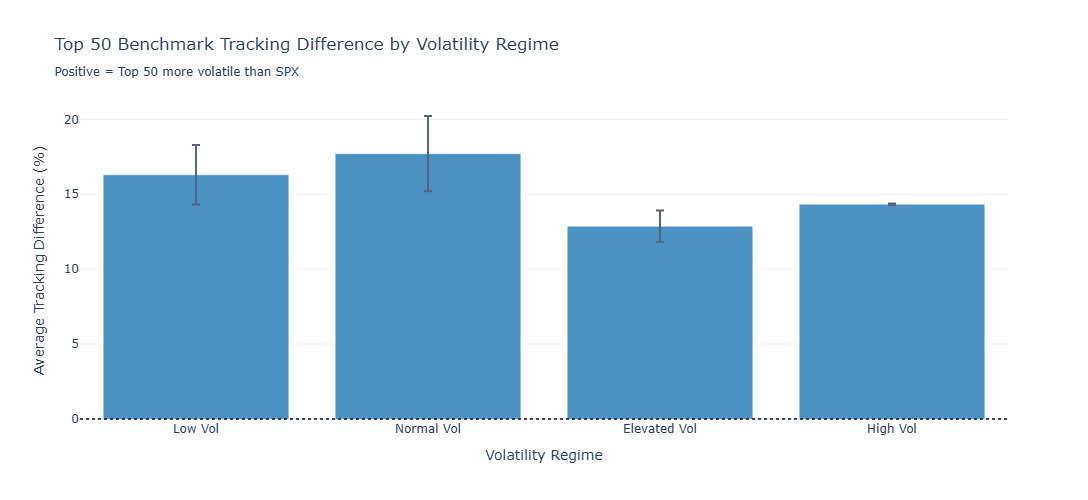

In [19]:
# Analyze tracking differences by volatility regime
if len(comparison_252d) > 0:
    print(f"\n🎭 TRACKING PERFORMANCE BY VOLATILITY REGIME")
    print("=" * 60)
    
    # Define volatility regimes based on SPX volatility
    comparison_252d['spx_vol_regime'] = pd.cut(
        comparison_252d['spx_vol'],
        bins=[0, 15, 25, 35, float('inf')],
        labels=['Low Vol', 'Normal Vol', 'Elevated Vol', 'High Vol']
    )
    
    comparison_252d['tracking_diff'] = comparison_252d['top50_benchmark_vol'] - comparison_252d['spx_vol']
    comparison_252d['abs_tracking_diff'] = abs(comparison_252d['tracking_diff'])
    
    # Calculate regime statistics
    regime_stats = comparison_252d.groupby('spx_vol_regime').agg({
        'top50_benchmark_vol': ['mean', 'std'],
        'spx_vol': ['mean', 'std'],
        'tracking_diff': ['mean', 'std'],
        'abs_tracking_diff': 'mean'
    }).round(3)
    
    print("Tracking Performance by Market Regime (252-day):")
    print(regime_stats)
    
    # Create regime tracking chart
    regime_summary = comparison_252d.groupby('spx_vol_regime').agg({
        'tracking_diff': ['mean', 'std'],
        'abs_tracking_diff': 'mean'
    }).round(3)
    
    regime_summary.columns = ['avg_tracking_diff', 'tracking_error', 'abs_tracking_diff']
    regime_summary = regime_summary.reset_index()
    
    fig = go.Figure()
    
    # Average tracking difference by regime
    fig.add_trace(go.Bar(
        x=regime_summary['spx_vol_regime'],
        y=regime_summary['avg_tracking_diff'],
        error_y=dict(type='data', array=regime_summary['tracking_error']),
        name='Average Tracking Difference',
        marker_color=top50_color,
        opacity=0.8
    ))
    
    fig.add_hline(y=0, line_dash="dot", line_color="black", opacity=0.7)
    
    fig.update_layout(
        title='Top 50 Benchmark Tracking Difference by Volatility Regime<br><sub>Positive = Top 50 more volatile than SPX</sub>',
        xaxis_title='Volatility Regime',
        yaxis_title='Average Tracking Difference (%)',
        template='plotly_white',
        height=500
    )
    
    fig.show()

#### Key Insights Summary

In [20]:
print(f"\n🎯 KEY INSIGHTS: TOP 50 BENCHMARK vs SPX TRACKING")
print("=" * 70)

if len(comparison_252d) > 0:
    correlation = comparison_252d['top50_benchmark_vol'].corr(comparison_252d['spx_vol'])
    avg_tracking_diff = tracking_diff.mean()
    tracking_error = tracking_diff.std()
    
    print(f"📊 CONCENTRATION vs DIVERSIFICATION EFFECTS:")
    print(f"   Top 50 represents ~{top_50_weights['normalized_weight'].sum():.0f}% of SPX market cap")
    print(f"   Tracking correlation: {correlation:.4f} ({correlation*100:.2f}%)")
    print(f"   Average tracking difference: {avg_tracking_diff:+.3f}%")
    
    if abs(avg_tracking_diff) < 0.1:
        tracking_assessment = "🟢 EXCELLENT tracking - minimal systematic difference"
    elif abs(avg_tracking_diff) < 0.3:
        tracking_assessment = "🟡 GOOD tracking - small systematic bias"
    else:
        tracking_assessment = "🔴 NOTICEABLE tracking difference"
    
    print(f"   Tracking assessment: {tracking_assessment}")
    print(f"   Tracking error (volatility): {tracking_error:.3f}%")
    
    print(f"\n📈 PORTFOLIO CONSTRUCTION INSIGHTS:")
    if avg_tracking_diff > 0:
        print(f"   • Top 50 concentration typically INCREASES volatility vs full SPX")
        print(f"   • Diversification benefit of remaining 450 names: {abs(avg_tracking_diff):.2f}%")
        print(f"   • Concentration risk premium: {avg_tracking_diff:.3f}% volatility points")
    else:
        print(f"   • Top 50 concentration typically DECREASES volatility vs full SPX")
        print(f"   • Large-cap bias provides volatility dampening: {abs(avg_tracking_diff):.3f}%")
    
    # Information ratio (excess tracking vs tracking error)
    info_ratio = avg_tracking_diff / tracking_error if tracking_error > 0 else 0
    print(f"   • Information ratio: {info_ratio:.3f}")
    
    print(f"\n💰 PRACTICAL APPLICATIONS:")
    print(f"   • Index fund replication: Top 50 achieves {correlation*100:.1f}% correlation")
    print(f"   • Cost reduction: Use 50 vs 500 names for similar exposure")
    print(f"   • Risk management: Understand concentration vs diversification trade-offs")
    print(f"   • Performance attribution: Isolate large-cap vs small-cap effects")
    
    # Calculate what percentage of full SPX vol is captured
    vol_capture_ratio = (top50_vol.std() / spx_vol.std()) if spx_vol.std() > 0 else 1
    print(f"   • Volatility capture ratio: {vol_capture_ratio:.3f} ({vol_capture_ratio*100:.1f}%)")

print(f"\n🎉 TOP 50 BENCHMARK ANALYSIS COMPLETE!")
print(f"This clean two-line analysis shows:")
print(f"• Concentration effects in large-cap portfolios")
print(f"• Tracking efficiency of simplified index replication")
print(f"• Quantified diversification benefits")
print(f"• Practical insights for portfolio construction")


🎯 KEY INSIGHTS: TOP 50 BENCHMARK vs SPX TRACKING
📊 CONCENTRATION vs DIVERSIFICATION EFFECTS:
   Top 50 represents ~100% of SPX market cap
   Tracking correlation: 0.9297 (92.97%)
   Average tracking difference: +16.588%
   Tracking assessment: 🔴 NOTICEABLE tracking difference
   Tracking error (volatility): 2.586%

📈 PORTFOLIO CONSTRUCTION INSIGHTS:
   • Top 50 concentration typically INCREASES volatility vs full SPX
   • Diversification benefit of remaining 450 names: 16.59%
   • Concentration risk premium: 16.588% volatility points
   • Information ratio: 6.414

💰 PRACTICAL APPLICATIONS:
   • Index fund replication: Top 50 achieves 93.0% correlation
   • Cost reduction: Use 50 vs 500 names for similar exposure
   • Risk management: Understand concentration vs diversification trade-offs
   • Performance attribution: Isolate large-cap vs small-cap effects
   • Volatility capture ratio: 1.012 (101.2%)

🎉 TOP 50 BENCHMARK ANALYSIS COMPLETE!
This clean two-line analysis shows:
• Concentr